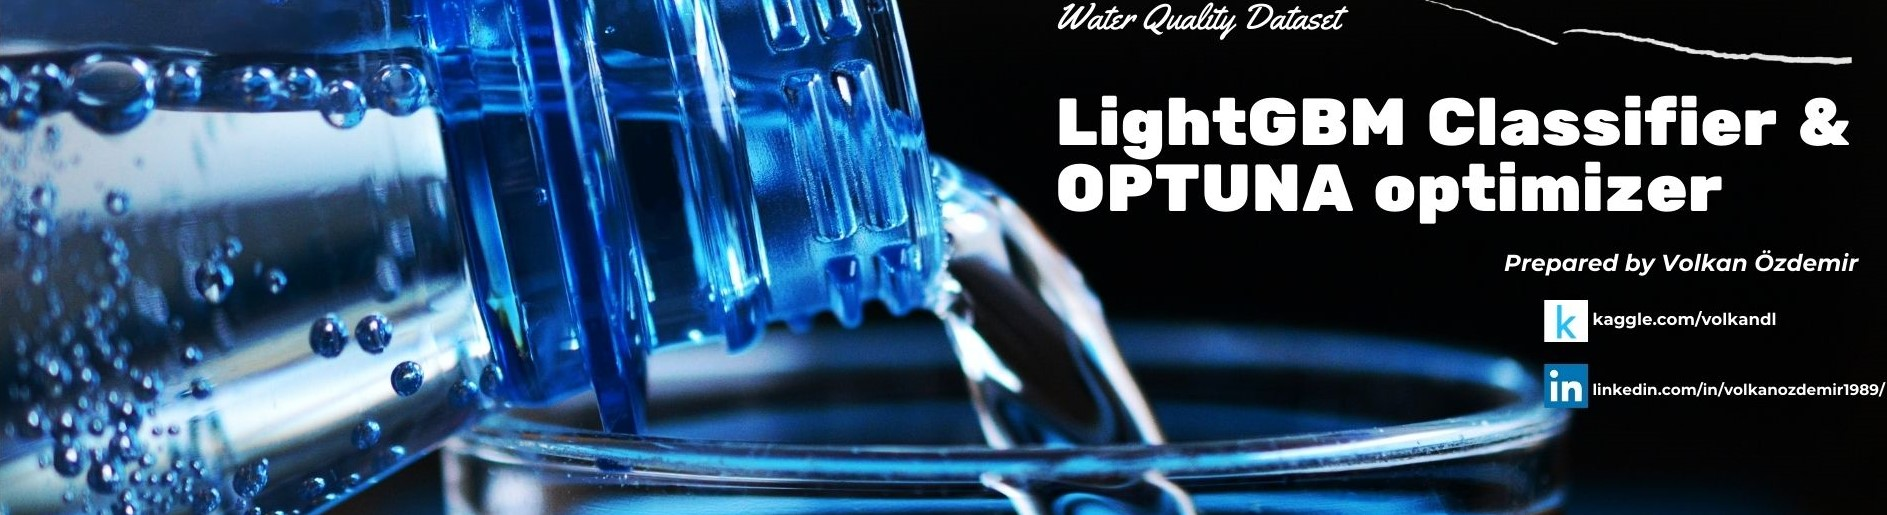

## $\color{Pink}{\text{Table of Contents}}$

* [Chapter 1. Introduction](#chapter1)     
* [Chapter 2. EDA & Missing Value Handling](#chapter2)
* [Chapter 3. SMOTE](#chapter3)
* [Chapter 4. OPTUNA & LightGBM Classifier](#chapter4)





 ##### ****$\color{Black}{\text{If You like my work, Please upvote!}}$****

## $\color{Pink}{\text{Chapter 1. Introduction}}$ <a class="anchor" id="chapter1"></a>

In [ ]:
import numpy as np 
import pandas as pd 
import os
import warnings
!pip install plotly==4.1.0
import plotly
from plotly.offline import iplot
warnings.filterwarnings("ignore")
print(plotly.__version__)
import seaborn as sns
import sklearn
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import pandas_profiling as pp
from sklearn.metrics import mean_absolute_error
import optuna
import optuna.integration.lightgbm as lgb
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

import lightgbm as lgb
from sklearn import metrics
from sklearn import model_selection
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from lightgbm import LGBMClassifier

For Hyperparameter optimization there are many methods such grid search and random search. Even if those old school methods work fine in many cases, for large datasets and for better accuracy matching there are softwares/libraries such as Optuna, Hyperopt , Spearmint , SMAC , Autotune , and Vizier. In this notebook i will try to use Optuna with one of on edge classifier called LightGBM.

In [ ]:
path=r"/kaggle/input/water-potability/water_potability.csv"
data = pd.read_csv(path)
data.head()
print("Data shape is {}".format(data.shape))

In [ ]:
#checking an arbitrary NaN value and its type
numm_example=data["ph"]
print("NaN value check : ", numm_example[0]," , type of NaN value :  ", type(numm_example[0]))

In [ ]:
data.head()

In [ ]:
data.dtypes

In [ ]:
data.describe()

In [ ]:
data['Potability'].value_counts()

In [ ]:
cat_col = data.select_dtypes("object").columns.tolist()
cat_col

## $\color{Pink}{\text{Chapter 2. EDA & Missing Value Handling}}$ <a class="anchor" id="chapter2"></a>

In [ ]:
pp.ProfileReport(data)

## Missing Value Handling

There are some ways to handle missing values in a dataframe. One should select the suitable method according to nature of the dataset and nature of the feature which contains missing values!! Hence there should be some exploratory analysis of those features first.

* Deleting Rows with missing values
* Impute missing values with Mean
* Impute missing values with Median
* Prediction of missing values (w/ ML or DL or Datawig [works fine categorical and non-numerical features.])


In [ ]:
data.isnull().sum()

We will check the distribution of the features without null walues, so we want to find the location (index) where missing values occur.

In [ ]:
missinglist_ph = list(data["ph"].isnull()) 
missinglist_sulfate = list( data["Sulfate"].isnull()) 
missinglist_Trihalomethanes=list(data["Trihalomethanes"].isnull()) 

index_missing_ph = np.where(missinglist_ph)  
index_missing_sulfate=np.where(missinglist_sulfate) 
index_missing_Trihalomethanes=np.where(missinglist_Trihalomethanes) 

In [ ]:
df_ph = data["ph"]
df_sulfate = data["Sulfate"]
df_Trih = data["Trihalomethanes"]
print("ph dim:",df_ph.shape)
print("sulfate dim:",df_sulfate.shape)
print("Trihalomethanes dim:",df_Trih.shape)

We clean the null values with droping JUST FOR EDA. We will decide to fill them or drop them according to analysis.

In [ ]:
df_ph2 = df_ph.drop(df_ph.index[index_missing_ph])
print("ph dim: ",df_ph2.shape)

df_sulfate2 = df_sulfate.drop(df_sulfate.index[index_missing_sulfate])
print("sulfate dim:",df_sulfate2.shape)

df_Trih2 = df_Trih.drop(df_Trih.index[index_missing_Trihalomethanes])
print("Trihalomethanes dim:",df_Trih2.shape)

In [ ]:
g=sns.distplot(df_ph2, color="r",  label="PH w/o nulls")
g.legend()
plt.show()

In [ ]:
g=sns.distplot(df_sulfate2, color="r",  label="Sulfate w/o nulls")
g.legend()
plt.show()

In [ ]:
g=sns.distplot(df_Trih2, color="r",  label="Trihalomethanes w/o nulls")
g.legend()
plt.show()

## A. Handling with Dropping NA Values

In [ ]:
data_dropped = data.dropna()
print("new shape: ",data_dropped.shape)
data_dropped.isnull().sum()

## B. Imputing By Mean or Median

In [ ]:
colnames=[]
for col in data.columns:
    colnames.append(col)    
print (colnames)

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
imp.fit(data)
data_impute_mean = imp.transform(data)
data_impute_mean = pd.DataFrame(data_impute_mean, columns = colnames)
data_impute_mean.isnull().sum()

In [ ]:
data_impute_mean.head()

In [ ]:
from sklearn.impute import SimpleImputer
imp_med = SimpleImputer(strategy='median')
imp_med.fit(data)
data_impute_med = imp_med.transform(data)
data_impute_med = pd.DataFrame(data_impute_med, columns = colnames)
data_impute_med.isnull().sum()

## C. Imputing by K Nearest Neighbours Algorithm

In [ ]:
from sklearn.impute import KNNImputer
imputer_knn = KNNImputer(n_neighbors=8, weights="uniform")
imputer_knn.fit(data)
data_impute_knn = imputer_knn.transform(data)
data_impute_knn = pd.DataFrame(data_impute_knn, columns = colnames)
data_impute_knn.isnull().sum()

 According to distrubition of the missing values, using **median imputer** will not affect the features' charactaristics so that we will use med imputer. You are free to use other imputing types.

## $\color{Pink}{\text{Chapter 3. SMOTE}}$ <a class="anchor" id="chapter3"></a>


It is nothing but a type of data augmentation for the unbalanced class and it is referred to as the **Synthetic Minority Oversampling Technique** (SMOTE). SMOTE is a better way of increasing the number of rare cases than simply duplicating existing cases. You are able to connect the SMOTE module to a dataset that is imbalanced. There are many reasons why a dataset might be imbalanced: the category you are targeting might be very rare in the population, or the data might simply be difficult to collect. Typically, you use SMOTE when the class you want to analyze is under-represented. The module returns a dataset that contains the original samples, plus an additional number of synthetic minority samples, depending on the percentage you specify.

source : Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: synthetic minority over-sampling technique. Journal of artificial intelligence research, 16, 321-357.

### Validation set split

In [ ]:
X = data_impute_med.iloc[:,:-1].values
y = data_impute_med["Potability"].values

In [ ]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
plt.figure(figsize=(8, 5))
plt.title("Potability Class Distribution Before SMOTE")
sns.countplot(x="Potability", data=data, palette='pastel');

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X , y, test_size=0.2)
print("X_train shape before smote: {} andn/ y_train shape before smote: {}".format(X_train.shape,y_train.shape))
print(type(X_train))

In [ ]:
y_train = y_train.astype(int)

In [ ]:
from imblearn.over_sampling import SMOTE 

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("X_train shape after smote: {} andn/ y_train shape after smote: {}".format(X_train_smote.shape,y_train_smote.shape))

In [ ]:
y_dist= pd.DataFrame(data=y_train_smote, index=range(y_train_smote.shape[0]),columns=["Potability"])
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
plt.figure(figsize=(8, 5))
plt.title("Potability Class Distribution After SMOTE")
sns.countplot(x="Potability", data=y_dist, palette='pastel');

## $\color{Pink}{\text{Chapter 4. OPTUNA & LightGBM Classifier}}$ <a class="anchor" id="chapter4"></a>

# Optuna Hyperparameter Optimization with LightGBM Classifier

Main Hyperparameters of LightGBM are:

* num_leaves [  Value more than  2^(max_depth) this will result in overfitting. ]
* min_data_in_leaf  
* max_depth
* learning_rate
* num_iterations
* regularization
* max_bin
* boosting type
* Cat_l2
* min_child_samples

Boosting types:

* "gbdt" : traditional Gradient Boosting Decision Tree

* "rf" : Random Forest

* "dart" : Dropouts meet Multiple Additive Regression Trees

* "goss" : Gradient-based One-Side Sampling

We will use gdbt which is default parameter.

In [ ]:
def objective(trial):

    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 10, 502),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 102),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.25),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.6),
        'cat_smooth' : trial.suggest_int('cat_smooth', 10, 102),
        'cat_l2': trial.suggest_int('cat_l2', 1, 20),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 1, 200),
        'n_estimators': trial.suggest_int('n_estimators', 300, 10000),
        'random_state': 42,
        'metric': 'binary_logloss'
    }
    
    model = LGBMClassifier(**params)    
    return cross_val_score(model, X_train_smote, y_train_smote, cv = 10, scoring = 'accuracy').mean()
optuna.logging.set_verbosity(optuna.logging.WARNING) 
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials=150, show_progress_bar=True)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

# Setting Best Parameters to the Model

In [ ]:
print(study.best_params)

In [ ]:
dtrain = lgb.Dataset(X, label=y)
best_params = {
    "objective": "binary",
    "metric": "binary_error",
    "verbosity": -1,
    "seed": 42} 
best_params.update(study.best_params)
best_params

#Actual training with best parameters
lgbfit = LGBMClassifier(**best_params,
                   
                   verbose_eval=False )

lgbfit.fit(X,y)

In [ ]:
from sklearn.metrics import accuracy_score

y_predd = lgbfit.predict(X_test)
recall_score(y_test, y_predd)
acc = accuracy_score(y_test, y_predd)
acc= acc*100
print("accuracy score of validation is {} %  .".format(acc))

# Conclusion

As conclusion we will investigate Water Quality dataset. We did following steps:


* We use a strategy to impute the missing values first. We check the nature of the featuures to use right imputing technique. We select median imputing since we do not have skew but translation.

* Afterwards, we split a part of data for the validation. This data is not used both in SMOTE and LightGBM training. 

* Then after spliting the train and validation set we balanced the data with using SMOTE technique. 

* For finding best parameters of LightGBM we use OPTUNA hyperparameter optimization engine. The important thing is, we have to use OPTUNA with crossvalidation!! Otherwise, our training will overfit without any doubts.

* After finding the best parameters, we train the LightGBM again.

* We test already splitted data with our model.